# <center>Tecnologias e Aplicações - TP2<center>

## <center>Data Augmentation<center>

### <center>Equipa<center>
    
<center> - A75569 - João Leal<center>
        
<center> - A74301 - Pedro Almeida<center>
    
<center> - A74357 - António Lopes<center>

# Introdução

&emsp;Os sinais de trânsito são responsáveis por garantir a segurança rodoviária, tanto ao condutor como ao peão, informando-os sobre quaisquer perigos ou como a condução se deve proceder, auxiliando a tomada de decisões aquando de um deslocamento. Este conjunto de sinais apresenta uma ampla gama de variações entre as suas classes em termos de cor, forma e presença de imagens ou texto. Assim, a detecção de sinais de trânsito é um problema de visão computacional de extrema relevância que apresenta várias utilidades na indústria automóvel. 
Com isto em mente, o trabalho prático que nos foi proposto passa por construir e treinar uma rede convulucional capaz de detetar as imagens de sinais de trânsito alemães e que depois classificará os sinais de trânsito não rotulados (*labeled*).
&emsp;Para isto usamos a API Keras que auxilia a construção de uma rede neuronal.

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import collections
import glob

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Funções auxiliares

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

### Load do dataset

&emsp;Para esta rede foi experimentado 3 batch sizes diferentes (16,32 e 64) mostrando melhores resultados para o batch de 64, uma vez que aumentamos o nosso dataset de imagens, através de augmentação de imagens. Assim, seguimos com um **batch size** de **64** com imagens de tamanho **32x32**.

In [22]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

data_dir = pathlib.Path('gtsrb/train_images/')
signs = list(data_dir.glob('00001/*'))
  
classNames = np.array(os.listdir(data_dir))

AUTOTUNE = 8

listset = tf.data.Dataset.list_files("gtsrb/train_images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = 4)

classNames

array(['00033', '00014', '00018', '00042', '00009', '00017', '00029',
       '00000', '00019', '00007', '00027', '00023', '00038', '00015',
       '00020', '00025', '00008', '00016', '00013', '00002', '00037',
       '00039', '00005', '00012', '00034', '00010', '00022', '00031',
       '00030', '00011', '00021', '00026', '00036', '00024', '00006',
       '00003', '00001', '00040', '00041', '00032', '00028', '00035',
       '00004'], dtype='<U5')

### Análise sobre o Dataset

<BarContainer object of 43 artists>

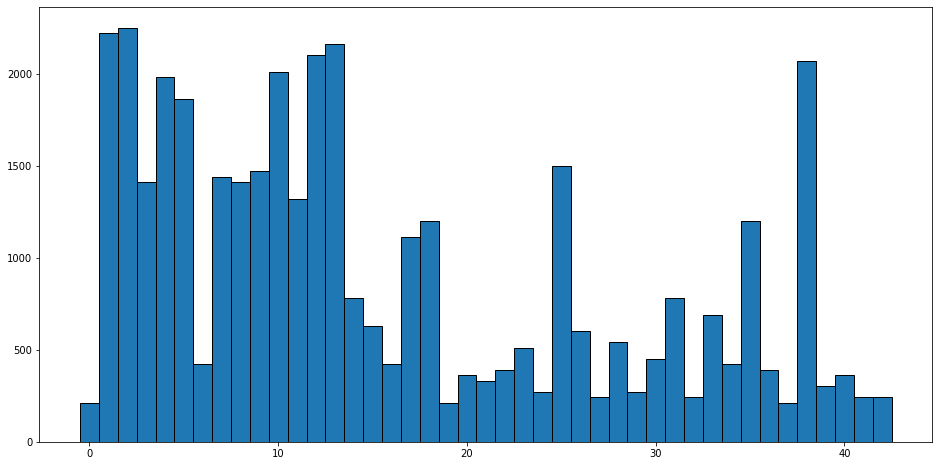

In [5]:
dic = {}

for folder in classNames:
    contents = os.listdir(os.path.join(data_dir,folder))
    dic[folder] = len(contents)
    
signs_per_label = collections.OrderedDict(sorted(dic.items()))

plt.figure(figsize=(16,8))
plt.bar(np.arange( 43 ), signs_per_label.values(),1.0, align='center',edgecolor='black')

In [7]:
for image, label in dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  
dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1
print("Total images in dataset: ",dataset_length)

Image shape:  (32, 32, 3)
Total images in dataset:  39209


&emsp;Como podemos ver pelo histograma, a distribuição de imagens presentes no dataset atual para cada classe varia bastante, aumentado o bias de classificação para certas classes de imagens. Assim, é necessário aumentar a quantidade de imagens para as outras classes de forma a obter melhores resultados.

In [ ]:
### Pré-Processamento de Imagens

In [6]:
import random

#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa

def process_image(image, label):
    
    # Resize -> (64x64)
    image = tf.image.resize(image, (64,64))
    
    # Rotation
    r = tf.random.uniform(shape=(), minval=0, maxval=1)* 0.65 - 0.25
    image = tfa.image.rotate(image, r)
    
    # Translation 
    rx = tf.random.uniform(shape=(), minval=0, maxval=1) * 20 - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=1) * 10 - 5
    
    image = tfa.image.translate(image, [rx, ry])
    
    # HSV tuning
    image = tfa.image.random_hsv_in_yiq(image, 0.6, 0.9, 1.1, 0.9, 1.3)
    
    # Grayscale Conversion
    image = tf.image.rgb_to_grayscale(image)
    
    # Adding Gaussian noise
    dev = 0.02
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=dev, dtype=tf.float32)
    image = tf.clip_by_value(tf.add(image, noise),0,1)
    
    # Resize -> (32x32)
    image = tf.image.resize(image, (32,32))
    
    # Brightness
    bright_val = tf.random.uniform(shape=(), minval=0, maxval=0.3)-0.1
    image = tf.clip_by_value(tf.image.adjust_brightness(image, bright_val),0,1)
    
    return image, label

### Aumento do Dataset

In [8]:
for label,count in signs_per_label.items():
    MAX_AUGMENT = 3000
    
    contents = glob.glob(f"{data_dir}/{label}/*.png")
    aug_counter = max(0,(MAX_AUGMENT - signs_per_label[label]))
    selected = []
    
    if(aug_counter > 0):
        print(f"{label} - Images are being augmented --> N = {aug_counter}")
                      
        while aug_counter > 0:
            selected.append(random.choice(contents))
            aug_counter -= 1
            
        list_ds = tf.data.Dataset.list_files(selected)
        aux_dset = list_ds.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

        dataset = dataset.concatenate(aux_dset)
        

for image, label in dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  
dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1
print("Total images in dataset: ",dataset_length)

00000 - Images are being augmented --> N = 2789
00001 - Images are being augmented --> N = 779
00002 - Images are being augmented --> N = 749
00003 - Images are being augmented --> N = 1589
00004 - Images are being augmented --> N = 1019
00005 - Images are being augmented --> N = 1139
00006 - Images are being augmented --> N = 2579
00007 - Images are being augmented --> N = 1559
00008 - Images are being augmented --> N = 1589
00009 - Images are being augmented --> N = 1529
00010 - Images are being augmented --> N = 989
00011 - Images are being augmented --> N = 1679
00012 - Images are being augmented --> N = 899
00013 - Images are being augmented --> N = 839
00014 - Images are being augmented --> N = 2219
00015 - Images are being augmented --> N = 2369
00016 - Images are being augmented --> N = 2579
00017 - Images are being augmented --> N = 1889
00018 - Images are being augmented --> N = 1799
00019 - Images are being augmented --> N = 2789
00020 - Images are being augmented --> N = 26

### Preparação do Dataset

In [9]:
dataset = dataset.map(process_image,num_parallel_calls = AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size = dataset_length)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

### Load e Preparação do Dataset de teste

In [10]:
def to_gray(image,label):
    return tf.image.rgb_to_grayscale(image),label

testset = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.map(to_gray, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)

### Batch de Imagens

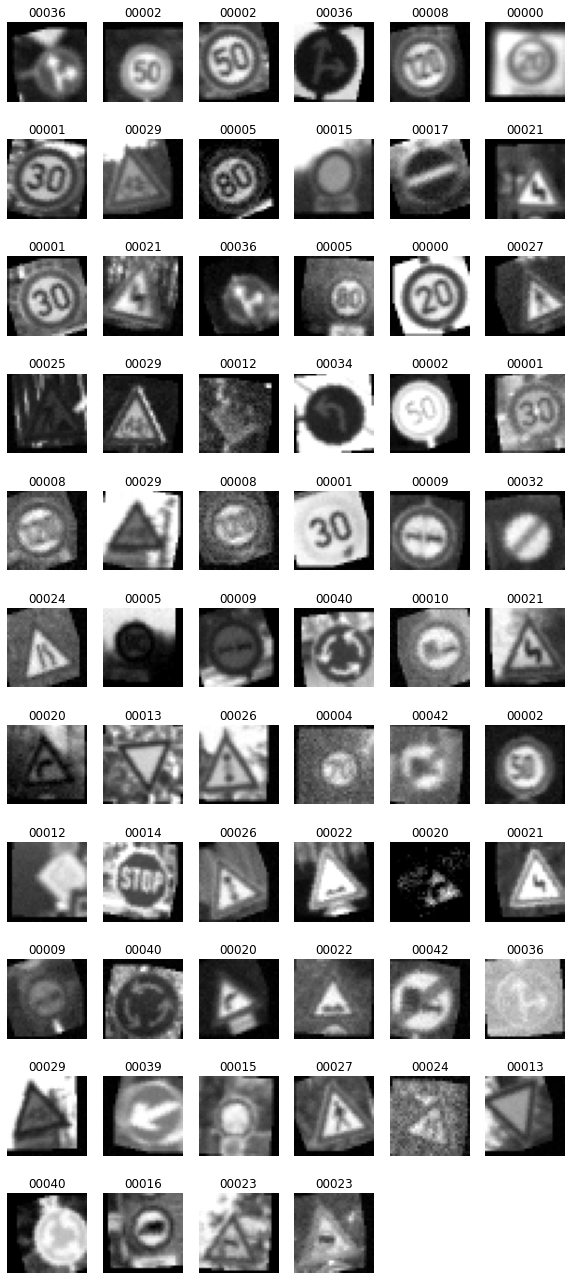

In [11]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow(np.squeeze((image_batch[n])),cmap='gray')
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(dataset))     
show_batch(image_batch, label_batch.numpy())

### Contrução da rede

&emsp; Aproveitando a rede criada anteriormente no TP1, decidimos fazer algumas alterações. Adicionamos uma layer de *Batch Normalization* no fim de cada convolução, descartando o dropout que tinhamos anteriormente, uma vez que produzia maus resultados se usado juntamente com a *Batch Normalization*. O número de filtros das layers convolucionais são duplicados após o *Max Pooling* por questões de performance. 

&emsp;Após o Flatten teremos apenas as 2 Layers principais onde teremos um dropout de 0.4 (valor descoberto após uma fase de  *hypertuning*) para a rede otimizar diversos caminhos para várias imagens. O modelo é compilado com o optimizer *Adam*, já disponibilizado na rede inicial. 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

def cnn55D3L2FC(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(imgSize, imgSize, channels),
                     activation='relu'))                     
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu') )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (5, 5), activation='relu') )     
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), activation='relu') )
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.43))
    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

model = cnn55D3L2FC(43, 32, 1)


### Arquitectura da Rede

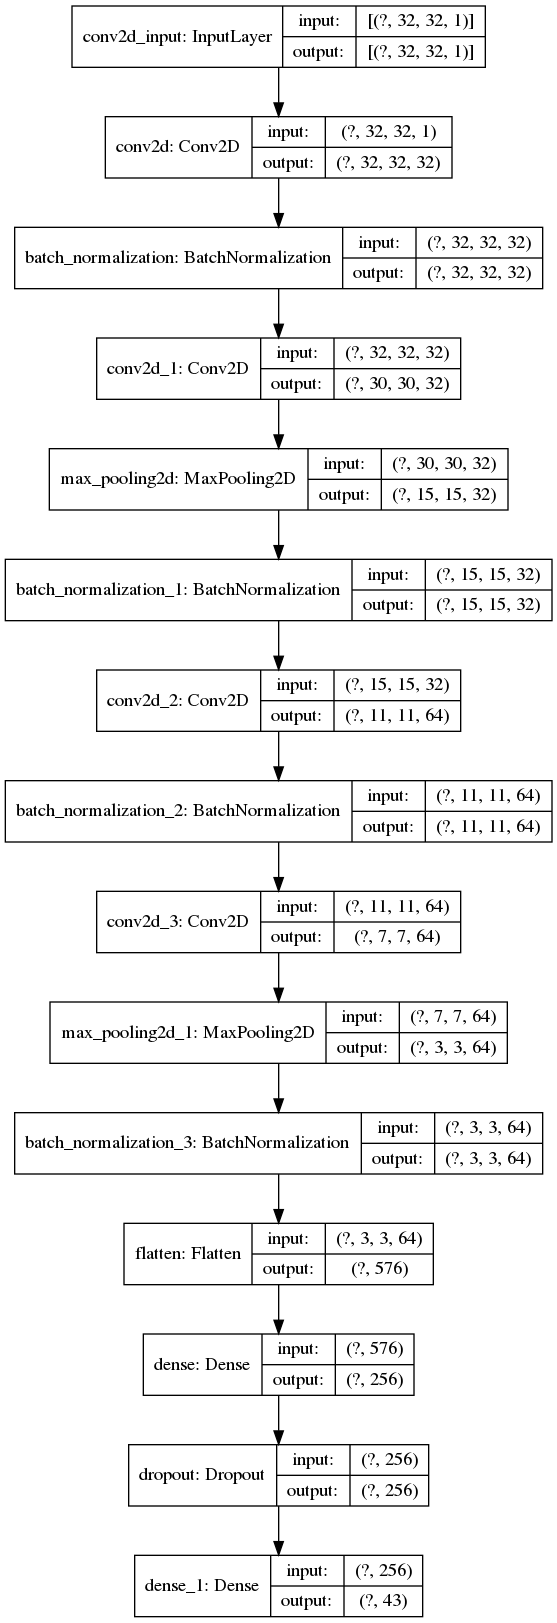

In [13]:
tf.keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)


### Sumarização da Rede

In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 11, 64)        2

### Criação do Dataset de Treino e Validação

In [15]:
train_size = int(0.8 * dataset_length)
val_size = int(0.2 * dataset_length)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(val_size)

### Treino do modelo

In [17]:
history = model.fit(dataset, steps_per_epoch = 0.8*dataset_length/BATCH_SIZE,
          epochs=30, validation_data = val_dataset, validation_steps= 0.2*dataset_length/BATCH_SIZE)


Train for 1611.9625 steps, validate for 402.990625 steps
Epoch 1/30
1612/1611 [==============================] - 73s 45ms/step - loss: 0.7181 - categorical_accuracy: 0.7971 - val_loss: 0.1887 - val_categorical_accuracy: 0.9434
Epoch 2/30
1612/1611 [==============================] - 70s 44ms/step - loss: 0.1164 - categorical_accuracy: 0.9650 - val_loss: 0.0790 - val_categorical_accuracy: 0.9758
Epoch 3/30
1612/1611 [==============================] - 70s 44ms/step - loss: 0.0855 - categorical_accuracy: 0.9745 - val_loss: 0.0737 - val_categorical_accuracy: 0.9768
Epoch 4/30
1612/1611 [==============================] - 70s 44ms/step - loss: 0.0690 - categorical_accuracy: 0.9793 - val_loss: 0.0335 - val_categorical_accuracy: 0.9892
Epoch 5/30
1612/1611 [==============================] - 70s 44ms/step - loss: 0.0609 - categorical_accuracy: 0.9815 - val_loss: 0.0170 - val_categorical_accuracy: 0.9945
Epoch 6/30
1612/1611 [==============================] - 70s 44ms/step - loss: 0.0482 - catego

### Plot do treino resultante

In [18]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


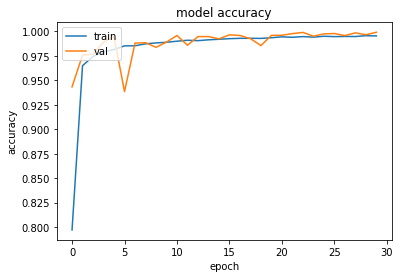

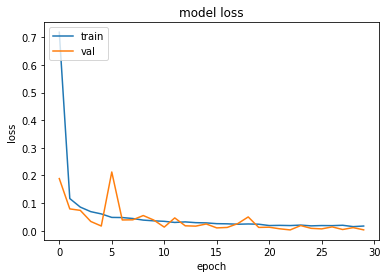

In [19]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Avaliação do Modelo

In [20]:
model.evaluate(testset)

198/198 [==============================] - 3s 15ms/step - loss: 0.1067 - categorical_accuracy: 0.9817


[0.10669283151070824, 0.9817102]

### Conclusão

&emsp;O resultado obtido foi na ordem dos **98.2%** , refletindo um aumento de **0.8%** quando comparado com a rede anterior, mostrando assim a importância do dataset escolhido assim como a importância do pré-processamento deste.  
&emsp;Finalizamos assim o trabalho prático, tendo correspondido ao proposto e culmatando os conceitos fundamentais relativos a redes convolucionais e à augmentação da informação processado por elas.